In [1]:
library("tidyverse")
library("data.table")
library("cowplot")
library("ggh4x")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [4]:
strain_labels <- c("iCab" = "icab", "HdrR" = "hdr", "Ho5" = "ho5", "Kaga" =  "kaga", "HNI" = "hni")

In [5]:
f_list <- list.files("/nfs/research/birney/users/saul/nextflow/medaka_behaviour_pilot/trajectories_csv/", full.names = TRUE)
df_positions <- lapply(f_list, function(f){fread(f)[, id := basename(f) |> str_remove("_traj_with_identities.csv.gz")]}) |> rbindlist(use.names = TRUE)
message("Read completed")
df_positions[, is_ref_ref := grepl("icab_icab", id)]
df_positions[, frame_n := 1:.N, by = id]
df_positions <- melt(
    df_positions[, .(id, frame_n, ref_x, ref_y, test_x, test_y)],
    id.vars = c("id", "frame_n")
)[
    , .(
        id,
        frame_n,
        axis = str_remove(variable, "^.*_"),
        fish_type = str_remove(variable, "_.*$"),
        value
    )
]
message("Melt completed")
df_positions <- dcast(df_positions, id + frame_n + fish_type ~ axis, measure.var = "value")
message("Dcast completed")
df_positions <- df_positions |>
    separate(
        id,
        into = c("date", "time_string", "ref_strain", "test_strain", "tank_side", "assay", "quadrant"),
        sep = "_",
        remove = FALSE
    ) |>
    as.data.table()
message("Separate completed")
df_positions[, test_strain := fct_recode(test_strain, !!!strain_labels)]
df_positions[, test_strain := fct_relevel(test_strain, function(x){names(strain_labels)})]
head(df_positions)

Read completed

Melt completed

Dcast completed

Separate completed



id,date,time_string,ref_strain,test_strain,tank_side,assay,quadrant,frame_n,fish_type,x,y
<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,1,ref,226.7195,67.81078
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,1,test,264.9209,44.03616
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,2,ref,226.3516,67.53082
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,2,test,264.9437,44.19932
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,3,ref,227.1498,68.52848
20190611_1331_icab_icab_R_no_q1,20190611,1331,icab,iCab,R,no,q1,3,test,264.9437,44.19932


In [29]:
df_positions[, assay_label := ifelse(assay == "of", "Open field", "Novel object")]
df_positions[, tank_side_label := ifelse(tank_side == "L", "Tank side L", "Tank side R")]
df_positions[
    , quadrant_label := ifelse(
        quadrant == "q1",
        "Quadrant 1",
        ifelse(
            quadrant == "q2",
            "Quadrant 2",
            ifelse(
                quadrant == "q3",
                "Quadrant 3",
                "Quadrant 4"
            )
        )
    )
]

In [56]:
p <- ggplot(df_positions, aes(x = x, y = y)) +
    stat_density_2d(aes(fill = after_stat(density)), geom = "raster", contour = FALSE) +
    scale_x_continuous(expand = expansion(mult = c(0, 0))) +
    scale_y_reverse(expand = expansion(mult = c(0, 0))) + # y is up to down
    scale_fill_distiller(palette = "RdBu") +
    facet_grid(fct_relevel(assay_label, "Open field") + tank_side_label ~ quadrant_label) +
    theme_cowplot(18) +
    theme(
        axis.line = element_blank(),
        axis.text = element_text(size = 10),
        strip.background = element_blank(),
        panel.background = element_rect(fill = "gray")
    ) +
    labs(y = "Position y (px)", x = "Position x (px)", fill = "Density")

Warning message:
“Removed 125399 rows containing non-finite outside the scale range
(`stat_density2d()`).”


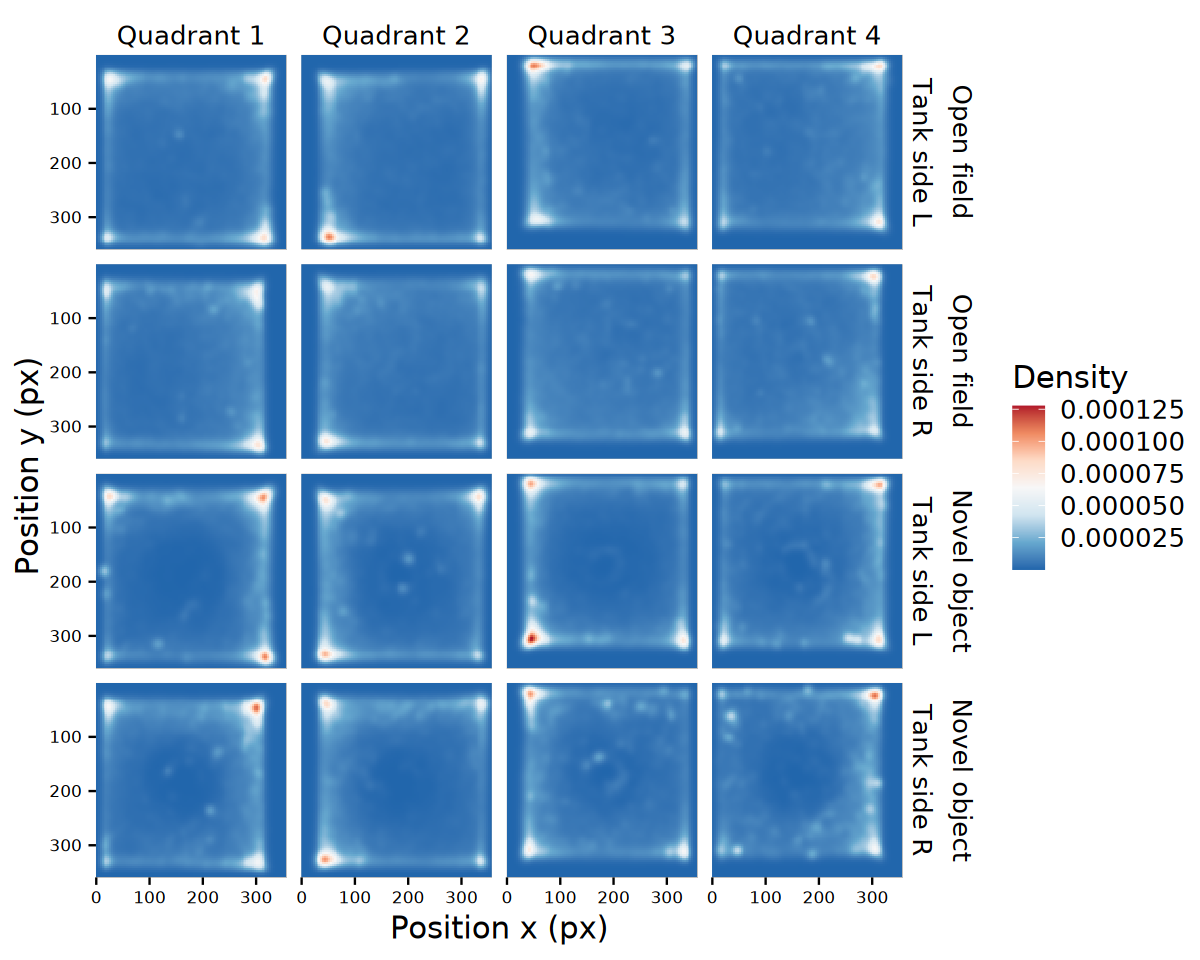

In [57]:
options(repr.plot.width = 10, repr.plot.height = 8)
p

In [58]:
ggsave("figS2.pdf", p, width = 10, height = 8)

Warning message:
“Removed 125399 rows containing non-finite outside the scale range
(`stat_density2d()`).”
